In [46]:
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from bitlinear import MNet

from train_utils import train_epoch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
device = torch.device('mps')
batch_size = 64
learning_rate = 0.001

# load datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)

train_subset_size = int(0.1 * len(train_dataset))
train_subset, val_set = random_split(train_dataset, [train_subset_size, len(train_dataset) - train_subset_size])
train_subset_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = MNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
num_epochs = 5
resumed_epoch = 0

loss_function = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# log training time
epoch_times = []

for epoch in range(num_epochs):
    # start timer
    start_time = time.time()

    train_epoch(model, train_loader, loss_function, optimizer, device, resumed_epoch + epoch)
    
    end_time = time.time()
    duration = end_time - start_time
    epoch_times.append(duration)

Training: 100%|██████████| 938/938 [00:09<00:00, 93.95it/s, loss=0.206] 


Epoch 0 finished, average loss: 0.3467


Training: 100%|██████████| 938/938 [00:09<00:00, 94.19it/s, loss=0.0594] 


Epoch 1 finished, average loss: 0.1621


Training: 100%|██████████| 938/938 [00:09<00:00, 95.10it/s, loss=0.0181] 


Epoch 2 finished, average loss: 0.1246


Training: 100%|██████████| 938/938 [00:10<00:00, 93.54it/s, loss=0.243]  


Epoch 3 finished, average loss: 0.1057


Training: 100%|██████████| 938/938 [00:09<00:00, 96.46it/s, loss=0.0475] 

Epoch 4 finished, average loss: 0.0918


In [45]:
model = model.to(device)

for samples, labels in train_loader:
    samples, labels = samples.to(device), labels.to(device)
    optimizer.zero_grad()

    preds = model(samples)
    print(model.fc1.weight.data)

    loss = loss_function(preds, labels)

    loss.backward()

    break



tensor([[ 0.,  1., -1.,  ..., -1.,  1.,  1.],
        [-1.,  0., -1.,  ...,  1., -1., -1.],
        [-1.,  0.,  1.,  ..., -1., -1.,  1.],
        ...,
        [-1.,  1.,  0.,  ..., -1.,  1.,  0.],
        [-1.,  1.,  0.,  ...,  0.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  0.,  1.,  1.]], device='mps:0')


## Eval Mode

In [71]:
test_dataset = datasets.MNIST(root='../../data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
def eval(model, test_loader, criterion, device):
    model.eval()

    # Visualize five outputs
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * data.size(0)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        fig = plt.figure(figsize=(10, 2))
        for idx in range(5):
            ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
            ax.imshow(images[idx].squeeze().cpu(), cmap='gray')
            ax.set_title(f"Predicted: {predicted[idx].cpu().item()}")
        plt.show()


    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')
    return accuracy, val_loss

In [73]:
model.fc1.weight.data

tensor([[ 1.9509e-02,  1.5961e-02,  5.0756e-03,  ...,  9.1232e-03,
          2.6573e-02,  2.8501e-03],
        [ 2.0155e-16,  2.0143e-16,  2.0149e-16,  ...,  2.0174e-16,
          2.0153e-16,  2.0178e-16],
        [-3.7545e-03, -5.1009e-03, -7.8201e-03,  ..., -1.1618e-02,
         -5.7745e-03, -1.1512e-02],
        ...,
        [ 1.9446e-26,  1.9457e-26,  1.9465e-26,  ...,  1.9446e-26,
          1.9540e-26,  1.9448e-26],
        [-1.7666e-02, -1.2579e-02, -1.2508e-02,  ..., -1.0235e-02,
          1.0259e-02, -9.1452e-03],
        [ 5.1044e-05,  5.1078e-05,  5.1044e-05,  ...,  5.1049e-05,
          5.1046e-05,  5.1057e-05]], device='mps:0')

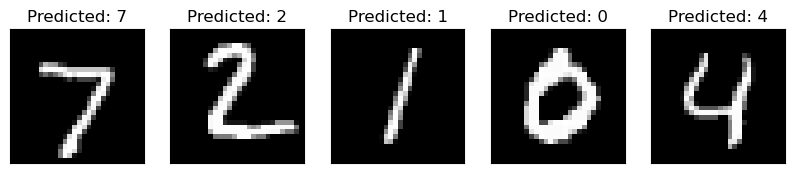

Accuracy on the test set: 98.44%


(98.4375, 2.2251150012016296)

In [74]:
eval(model, test_loader, loss_function, device)

In [75]:
from bitlinear import quantization_function

model2 = MNet().to(device)

model2.fc1.weight.data = quantization_function(model.fc1.weight.data)
model2.fc1.bias.data = model.fc1.bias.data
model2.fc2.weight.data = quantization_function(model.fc2.weight.data)
model2.fc2.bias.data = model.fc2.bias.data
model2.fc3.weight.data = quantization_function(model.fc3.weight.data)
model2.fc3.bias.data = model.fc3.bias.data

In [76]:
model2.fc1.weight.data

tensor([[ 1.,  1.,  0.,  ...,  1.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., -1.,  ..., -1.,  0., -1.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [-1., -1., -1.,  ..., -1.,  1., -1.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='mps:0')

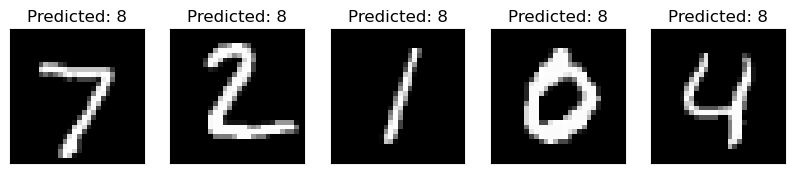

Accuracy on the test set: 3.12%


(3.125, 1516464.28125)

In [78]:
eval(model2, test_loader, loss_function, device)

In [79]:
def custom_weight_update(weight, gradient, learning_rate, momentum_value):
    """
    Custom weight update function for weights in the range (-1, 0, 1) using PyTorch with momentum.
    Allows weights to shift towards 1, 0, or -1 based on the gradient direction.
    
    Args:
        weight (torch.Tensor): Current weight tensor.
        gradient (torch.Tensor): Gradient tensor of the weights.
        learning_rate (float): Learning rate for weight updates.
        momentum_value (float): Momentum value for SGD with momentum.
        
    Returns:
        torch.Tensor: Updated weight tensor.
    """
    # Compute the tentative weight update with momentum
    tentative_update = momentum_value * weight.detach() - learning_rate * gradient
    
    # Determine the sign of the tentative update
    update_sign = torch.sign(tentative_update)
    
    # Clamp the tentative update to the desired range
    clamped_update = tentative_update.clamp(-1, 1)
    
    # Update the weights based on the sign of the tentative update
    new_weight = torch.where(update_sign == 0, torch.zeros_like(weight),
                             update_sign * torch.ones_like(weight))
    
    # Incorporate the clamped update for non-zero weights
    new_weight = torch.where(new_weight == 0, clamped_update, new_weight)
    
    return new_weight

## Overfit on subset of data

In [80]:
learning_rate = 0.001
momentum = 0.9

criterion = torch.nn.CrossEntropyLoss()

# model2 = MNet().to(device)

optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)

model2.fc1.weight.data

tensor([[ 1.9509e-02,  1.5961e-02,  5.0756e-03,  ...,  9.1232e-03,
          2.6573e-02,  2.8501e-03],
        [ 2.0155e-16,  2.0143e-16,  2.0149e-16,  ...,  2.0174e-16,
          2.0153e-16,  2.0178e-16],
        [-3.7545e-03, -5.1009e-03, -7.8201e-03,  ..., -1.1618e-02,
         -5.7745e-03, -1.1512e-02],
        ...,
        [ 1.9446e-26,  1.9457e-26,  1.9465e-26,  ...,  1.9446e-26,
          1.9540e-26,  1.9448e-26],
        [-1.7666e-02, -1.2579e-02, -1.2508e-02,  ..., -1.0235e-02,
          1.0259e-02, -9.1452e-03],
        [ 5.1044e-05,  5.1078e-05,  5.1044e-05,  ...,  5.1049e-05,
          5.1046e-05,  5.1057e-05]], device='mps:0')

In [60]:
def train(model, train_loader, val_loader, criterion, optimizer, learning_rate, momentum, device):
    train_losses = []
    val_losses = []
    for epoch in range(5):
        train_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training')

        for i, (data, labels) in progress_bar:
            data, labels = data.to(device), labels.to(device)
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)

            # Backward pass and gradient computation
            optimizer.zero_grad()
            loss.backward()

            # Custom weight update
            for param in model.parameters():
                if param.grad is not None:
                    param.data = custom_weight_update(param.data, param.grad.data, learning_rate, momentum)

            train_loss += loss.item() * data.size(0)
            progress_bar.set_postfix(loss=loss.item())

        val_acc, val_loss = eval(model2, val_loader, criterion, device)
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        train_losses.append(train_loss)

    return train_losses, val_losses


Training: 100%|██████████| 94/94 [00:01<00:00, 83.83it/s, loss=3.55e+3]


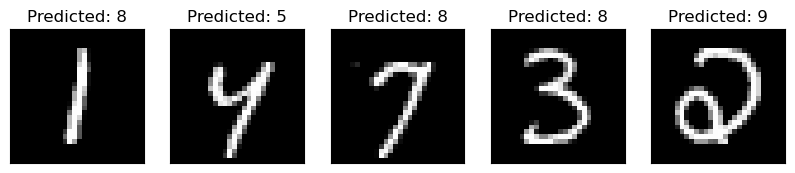

Accuracy on the test set: 10.94%


Training: 100%|██████████| 94/94 [00:01<00:00, 87.08it/s, loss=3.74e+3]


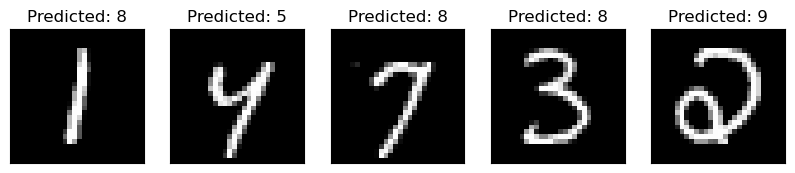

Accuracy on the test set: 10.94%


Training: 100%|██████████| 94/94 [00:01<00:00, 88.86it/s, loss=3.37e+3]


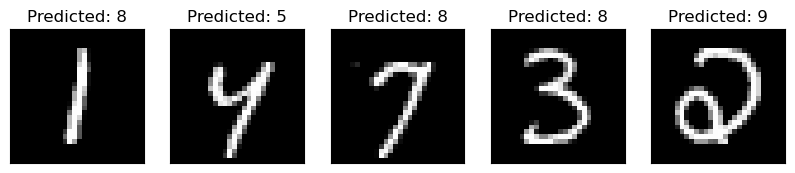

Accuracy on the test set: 10.94%


Training: 100%|██████████| 94/94 [00:01<00:00, 91.08it/s, loss=3.97e+3]


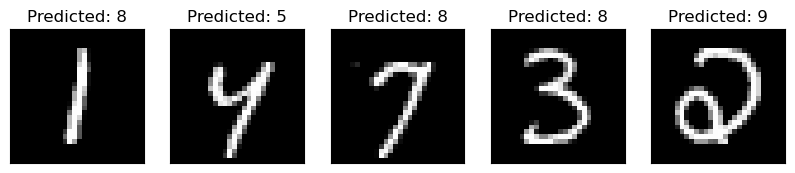

Accuracy on the test set: 10.94%


Training: 100%|██████████| 94/94 [00:01<00:00, 90.18it/s, loss=3.65e+3]


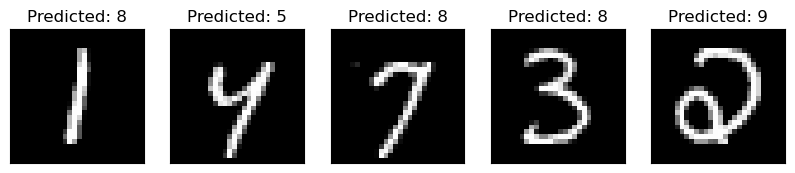

Accuracy on the test set: 10.94%


In [61]:
train_losses, val_losses = train(model2, train_subset_loader, val_loader, criterion, optimizer, learning_rate, momentum, device)

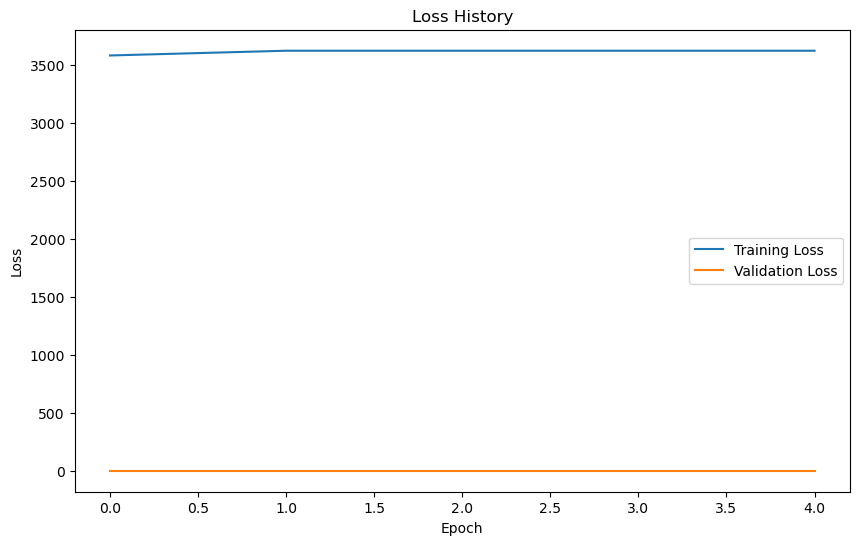

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

In [68]:
eval(model2, test_loader, criterion, device)

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [64]:
model2.fc1.weight.data

tensor([[ 1., -1.,  1.,  ...,  1.,  1., -1.],
        [ 1., -1.,  1.,  ...,  1., -1., -1.],
        [-1., -1.,  1.,  ...,  1., -1., -1.],
        ...,
        [ 1.,  1., -1.,  ..., -1., -1.,  1.],
        [-1., -1., -1.,  ..., -1.,  1., -1.],
        [-1.,  1., -1.,  ..., -1.,  1., -1.]], device='mps:0')